Importing datset from kaggle

In [1]:
from google.colab import files

# Upload the Kaggle API token
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d veeralakrishna/butterfly-dataset


 96% 436M/454M [00:04<00:00, 78.5MB/s]
100% 454M/454M [00:04<00:00, 111MB/s] 


In [4]:
!unzip -q butterfly-dataset.zip


Implementing dataset to dataframe

In [5]:
import os
import cv2
import re
import numpy as np

# Assuming you have already downloaded and unzipped the dataset in the previous steps
root_dir = "/content/leedsbutterfly/images"

data = []
labels = []

# Adjust the path based on the structure of the Butterfly dataset
for file in os.listdir(root_dir):
    if file.endswith(".png"):
        match = re.search(r'^(\d+)', file)  # Extract the numeric part from the beginning of the file name
        if match:
            label = int(match.group())
            img = cv2.imread(os.path.join(root_dir, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            data.append(img)
            labels.append(label)
            print(f"Processed: {file}")

# Convert lists to numpy arrays for easier handling
data = np.array(data)
labels = np.array(labels)

# Print the shapes to check if data and labels are loaded correctly
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


Processed: 0060175.png
Processed: 0010067.png
Processed: 0040049.png
Processed: 0070110.png
Processed: 0020110.png
Processed: 0090118.png
Processed: 0090156.png
Processed: 0040055.png
Processed: 0090078.png
Processed: 0060228.png
Processed: 0050067.png
Processed: 0090117.png
Processed: 0070017.png
Processed: 0100110.png
Processed: 0100122.png
Processed: 0060093.png
Processed: 0070066.png
Processed: 0100006.png
Processed: 0010030.png
Processed: 0020105.png
Processed: 0040070.png
Processed: 0010039.png
Processed: 0010053.png
Processed: 0090084.png
Processed: 0040152.png
Processed: 0050051.png
Processed: 0070003.png
Processed: 0070092.png
Processed: 0080029.png
Processed: 0060217.png
Processed: 0100008.png
Processed: 0020171.png
Processed: 0020076.png
Processed: 0060154.png
Processed: 0010046.png
Processed: 0100171.png
Processed: 0010036.png
Processed: 0010071.png
Processed: 0010061.png
Processed: 0100151.png
Processed: 0010083.png
Processed: 0070010.png
Processed: 0070064.png
Processed: 

In [6]:
images=os.listdir('/content/leedsbutterfly/images')
masks=os.listdir('/content/leedsbutterfly/segmentations')
print(f"The Data statistics\n images: {len(images)} masks:{len(masks)}")

The Data statistics
 images: 832 masks:832


['0040141.png', '0050036.png', '0070052.png', '0090219.png', '0050040.png']


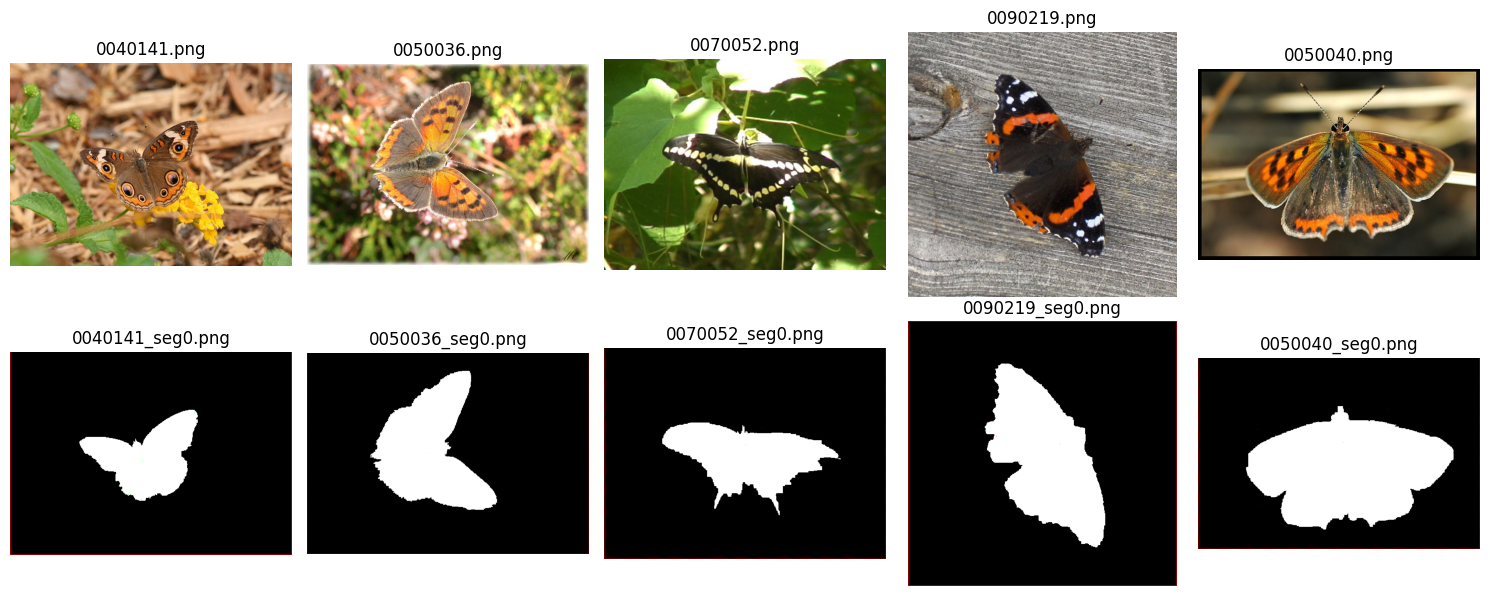

In [7]:
import random
import matplotlib.pyplot as plt
def plot_random_images_with_masks(images, masks):
  """
  Plots 5 random images and their corresponding masks in 2 rows.
  Args:
    images: A list of image paths.
    masks: A list of mask paths, corresponding to the images.
  """
  # Select 5 random images and masks images
  random_indices = random.sample(range(len(images)), 5)
  selected_images = [images[i] for i in random_indices]
  selected_masks = [masks[i] for i in random_indices]
  print(selected_images)
  # Create a figure with 2 rows and 5 columns
  fig, axes = plt.subplots(2, 5, figsize=(15, 6))
  # Plot images and masks
  for i, (image_path, mask_path) in enumerate(zip(selected_images, selected_masks)):
      # Plot image
      path="/content/leedsbutterfly/images/"+image_path
      axes[0, i].imshow(plt.imread(path))
      axes[0, i].set_title(image_path)
      axes[0, i].axis("off")

      # Plot mask
      path=image_path.split(".")[0]+"_seg0.png"
      mask_path="/content/leedsbutterfly/segmentations/"+path
      axes[1, i].imshow(plt.imread(mask_path))
      axes[1, i].set_title(path)
      axes[1, i].axis("off")
  plt.tight_layout()
  plt.show()
plot_random_images_with_masks(images, masks)

In [8]:
import re
import cv2

In [9]:
Train_data = {'img' : [],'mask' : []}

def Get_Data( dicts = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    ## generating mask names
    for p in imgNames:
        maskNames.append(re.sub('\.png', '_seg0.png', p))
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + imgNames[i])
            mask = plt.imread(maskAddr + maskNames[i])

        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        dicts['img'].append(img)
        dicts['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

    return dicts

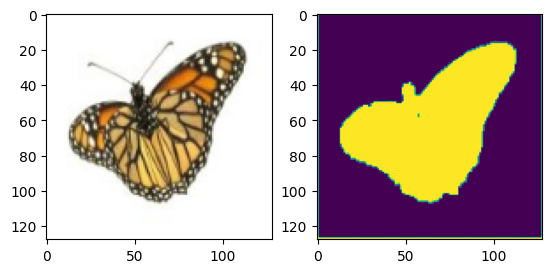

832,832


In [10]:
Train_datas=Get_Data(Train_data,'/content/leedsbutterfly/images/','/content/leedsbutterfly/segmentations/')
plt.subplot(1,2,1)
plt.imshow(Train_datas['img'][1])
plt.subplot(1,2,2)
plt.imshow(Train_datas['mask'][1])
plt.show()
print(f"{len(Train_datas['img'])},{len(Train_datas['mask'])}")

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from keras.models import Model, Sequential

In [12]:
def convolutional_block(entered_input,filters):
    """
    Apply a convolutional block to the input tensor.

    Args:
        entered_input (tf.Tensor): Input tensor to the convolutional block.

    Returns:
        tf.Tensor: Output tensor after applying the convolutional block.
    """
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size=(3, 3), padding="same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)

    # Taking previous output and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size=(3, 3), padding="same")(act1)
    batch_norm2 = BatchNormalization()(conv2)  # gives best result than not using
    act2 = ReLU()(batch_norm2)

    return act2

In [13]:
def encoder(entered_input, filters=64):
    """
    Encoder block in the U-Net architecture.

    Args:
        entered_input (tf.Tensor): Input tensor to the encoder block.
        filters (int): Number of filters for the convolutional layers.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: Tuple containing the output tensors of the convolutional block
                                     and the corresponding max-pooling layer.
    """
    # Collect the start and end of each sub-block for normal pass and skip connections
    # convolutional block
    enc1 = convolutional_block(entered_input, filters)
    # Max pooling to downsample the spatial dimensions
    MaxPool1 = MaxPooling2D(strides=(2, 2))(enc1)
    return enc1, MaxPool1

In [14]:
def decoder(entered_input, skip, filters=64):
    """
    Decoder block in the U-Net architecture.

    Args:
        entered_input (tf.Tensor): Input tensor to the decoder block.
        skip (tf.Tensor): Skip connection tensor from the corresponding encoder block.
        filters (int): Number of filters for the convolutional layers.

    Returns:
        tf.Tensor: Output tensor after applying the decoder block.
    """
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    # Applying a convolutional block
    out = convolutional_block(Connect_Skip, filters)
    return out

In [15]:
def U_Net(Image_Size):
    # input layer
    input1 = Input(Image_Size)

    # encoder blocks as paper the no of filters increases in encoder and vice versa in decoder
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Preparing the next block
    conv_block = convolutional_block(encoder_4, 64*16)

    # decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

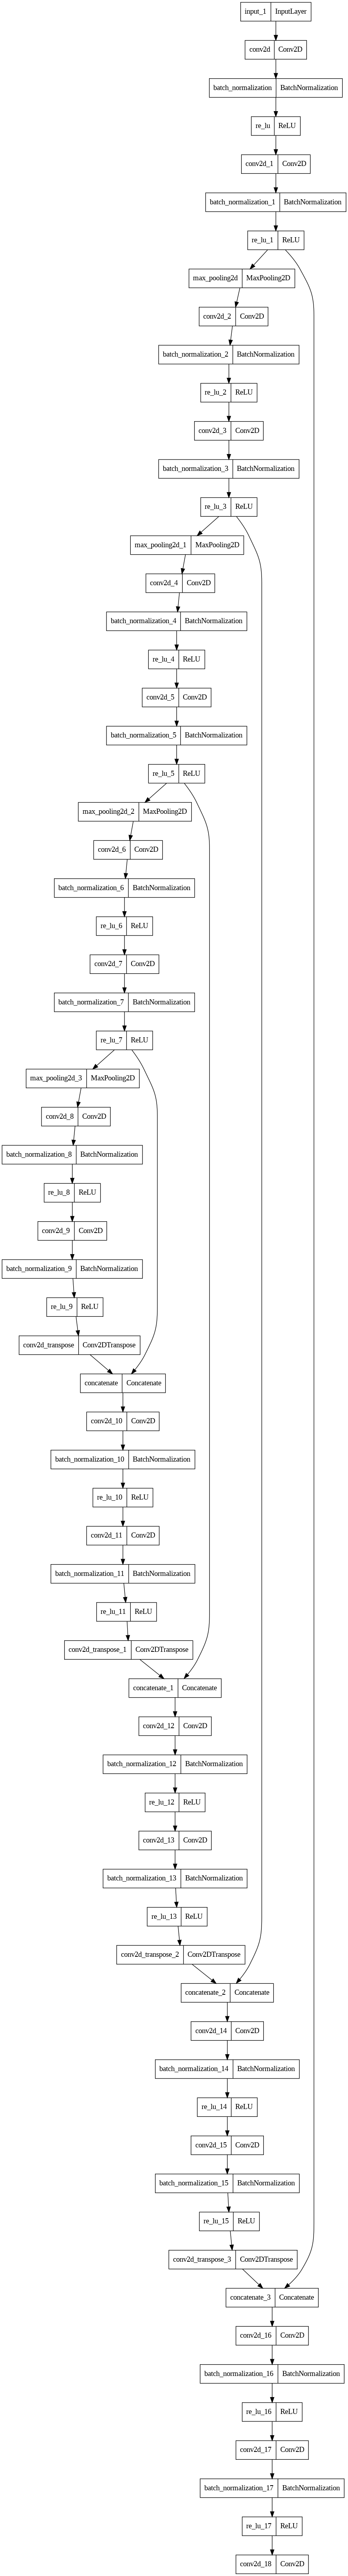

In [16]:
from keras.utils import plot_model
input_shape = (128, 128, 3)
model = U_Net(input_shape)
plot_model(model, "model_arch.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 128, 128, 64)         0         ['batch_normalization[0][0

In [18]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00


In [19]:
class EarlyStopping(tf.keras.callbacks.Callback):
  """
  Early stops training if the validation loss plateaus for a specified patience.
  Args:
    monitor: Quantity to monitor for early stopping (e.g., 'val_loss').
    patience: Number of epochs to wait for improvement before stopping.
    restore_best_weights: Whether to restore the model weights with the best
                         validation loss (default: True).
  """
  def __init__(self, monitor='val_loss', patience=5, restore_best_weights=True):
    super(EarlyStopping, self).__init__()
    self.monitor = monitor
    self.patience = patience
    self.best_weights = None
    self.wait = 0
    self.restore_best_weights = restore_best_weights

  def on_epoch_end(self, epoch, logs=None):
    current = logs.get(self.monitor)
    if self.best_weights is None or current < self.best_weights:
      self.best_weights = current
      self.wait = 0
    else:
      self.wait += 1
    if self.wait >= self.patience:
      self.model.stop_training = True
      if self.restore_best_weights:
        self.model.set_weights(self.best_weights)

In [20]:
class ModelCheckpoint(tf.keras.callbacks.Callback):
  """
  Saves the model at regular intervals or when the monitored metric improves.
  Args:
    filepath: Path to save the model.
    monitor: Quantity to monitor for saving (e.g., 'val_loss').
    save_best_only: Whether to only save the model with the best metric.
    save_freq: Frequency (in epochs) to save the model (default: 1 epoch).
  """
  def __init__(self, filepath, monitor='val_loss', save_best_only=True, save_freq=1):
    super(ModelCheckpoint, self).__init__()
    self.filepath = filepath
    self.monitor = monitor
    self.save_best_only = save_best_only
    self.save_freq = save_freq
    self.best_weights = None

  def on_epoch_end(self, epoch, logs=None):
    if (epoch + 1) % self.save_freq == 0 or (self.save_best_only and logs.get(self.monitor) is not None and
        (self.best_weights is None or logs.get(self.monitor) < self.best_weights)):
      self.best_weights = logs.get(self.monitor)
      self.model.save_weights(self.filepath)

In [21]:
class TensorBoardCallback(tf.keras.callbacks.TensorBoard):
  """
  Logs training and validation metrics to TensorBoard.
  Args:
    log_dir: Directory to store TensorBoard logs.
    histogram_freq: Frequency (in epochs) to log histograms (default: 0).
    write_images: Whether to log input and output images (default: True).
  """

  def __init__(self, log_dir, histogram_freq=0, write_images=True):
    super(TensorBoardCallback, self).__init__(log_dir=log_dir, histogram_freq=histogram_freq, write_images=write_images)

  def on_epoch_end(self, epoch, logs=None):
    # Add custom image visualizations to TensorBoard here
    # ...
    super(TensorBoardCallback, self).on_epoch_end(epoch, logs)


In [22]:
class MeanIoU(tf.keras.metrics.Metric):
  """
  Calculates the mean Intersection over Union (IoU) for each class.
  """
  def __init__(self, num_classes):
    super(MeanIoU, self).__init__(name='mean_iou')
    self.num_classes = num_classes
    self.iou_per_class = tf.keras.metrics.IoU(num_classes=num_classes)
    self.total_iou = tf.keras.metrics.Mean()

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
# miou=MeanIoU(num_classes=2)
tensorboard=TensorBoardCallback('/tensor/log')
earlystopping=EarlyStopping()
checkpointing=ModelCheckpoint('/checkpointing')
callback=[earlystopping,checkpointing]
from keras import callbacks
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
    # early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [24]:
from keras import backend as K
def dice_coeff(y_true, y_pred, smooth = 1):
    intersection = K.sum(y_true*y_pred, axis = -1)
    union = K.sum(y_true, axis = -1) + K.sum(y_pred, axis = -1)
    dice_coeff = (2*intersection+smooth) / (union + smooth)
    return dice_coeff

In [25]:
train_img=np.array(Train_datas['img'][0:600])
train_mask=np.array(Train_datas['mask'][0:600])
# test
test_img=np.array(Train_datas['img'][600:-1])
test_mask=np.array(Train_datas['mask'][600:-1])

In [26]:
input_shape=(128,128,3)
bs=4
model = U_Net(input_shape)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy', dice_coeff])

In [53]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00


In [28]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [29]:
import wandb
wandb.init(project='Segmentation',name=f"batch-size_early:{bs}")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [30]:
hyper_p={
    "batch_size":bs,
    "val_split":0.2,
    "train_no":600,
    "test_no":232,
    "shape":"128,128",
    "callbacks":"[lr-scheduler,ealy_stopping]",
    "optimizer":"adam",
    "loss":"binary_crossentropty",
    "metrics":"[accuracy,dice_coeff]"
}
wandb.config.update(hyper_p)

In [31]:
history=model.fit(train_img,train_mask,epochs=70,validation_split=.2,shuffle=True,
                  batch_size=bs,steps_per_epoch=len(train_img)//bs,
                  callbacks=[lr_scheduler,early_stopping])

Epoch 1/70
150/150 [==============================] - 50s 106ms/step - loss: 0.3182 - accuracy: 0.8618 - dice_coeff: 0.4154 - val_loss: 1.9507 - val_accuracy: 0.7283 - val_dice_coeff: 0.4131 - lr: 0.0010
Epoch 2/70
150/150 [==============================] - 15s 98ms/step - loss: 0.2131 - accuracy: 0.9036 - dice_coeff: 0.5330 - val_loss: 0.4777 - val_accuracy: 0.8455 - val_dice_coeff: 0.6361 - lr: 0.0010
Epoch 3/70
150/150 [==============================] - 15s 99ms/step - loss: 0.1875 - accuracy: 0.9121 - dice_coeff: 0.5780 - val_loss: 0.3487 - val_accuracy: 0.8728 - val_dice_coeff: 0.6822 - lr: 0.0010
Epoch 4/70
150/150 [==============================] - 15s 99ms/step - loss: 0.1627 - accuracy: 0.9247 - dice_coeff: 0.6123 - val_loss: 0.2335 - val_accuracy: 0.9103 - val_dice_coeff: 0.7034 - lr: 0.0010
Epoch 5/70
150/150 [==============================] - 15s 103ms/step - loss: 0.1534 - accuracy: 0.9276 - dice_coeff: 0.6325 - val_loss: 0.1997 - val_accuracy: 0.9058 - val_dice_coeff: 0.6

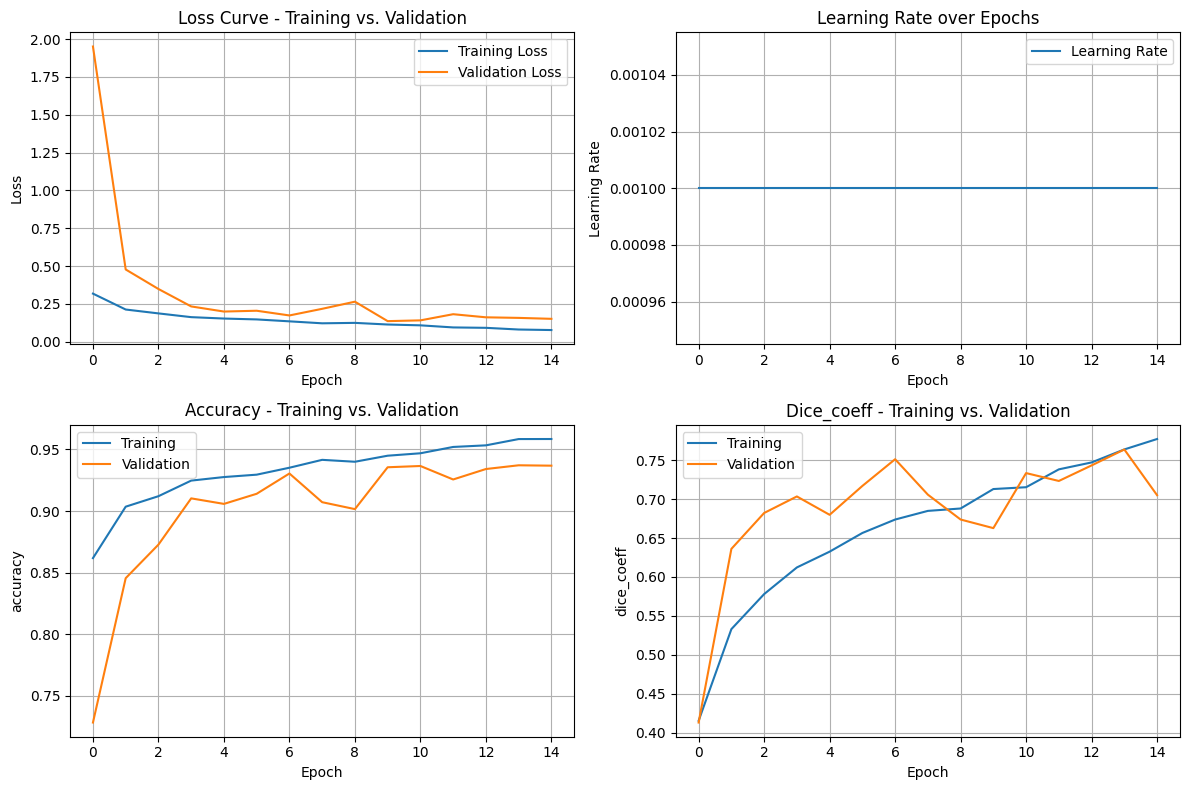

Saved in wandb


In [32]:
import wandb
def history_save(history, experiment_name=None):
    """
    Saves and displays training history plots, logging metrics to W&B.

    Args:
        history: Training history object returned by your model training process.
        experiment_name: Optional name for the W&B experiment (if you're using W&B).
    """

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Adjusted figure size

    # Loss comparison plot
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss Curve - Training vs. Validation')
    axes[0, 0].grid(True)
    axes[0, 0].legend()

    # Epoch vs LR plot (assuming history contains 'lr')
    if 'lr' in history.history:
        axes[0, 1].plot(history.history['lr'], label='Learning Rate')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Learning Rate')
        axes[0, 1].set_title('Learning Rate over Epochs')
        axes[0, 1].grid(True)
        axes[0, 1].legend()

    # Accuracy and Dice Coeff plots
    for metric, subplot in zip(['accuracy', 'dice_coeff'], axes[1]):
        if metric=='dice_coeff':
            col=1
        else:
            col=0
        axes[1,col].plot(history.history[metric], label='Training')
        axes[1,col].set_ylabel(metric)
        axes[1,col].grid(True)
        axes[1,col].legend()

        axes[1,col].plot(history.history['val_' + metric], label='Validation')
        axes[1,col].set_ylabel(metric)
        axes[1,col].grid(True)
        axes[1,col].legend()

        axes[1,col].set_xlabel('Epoch')
        axes[1,col].set_title(metric.capitalize() + ' - Training vs. Validation')

    plt.tight_layout()
    plt.savefig(f'training_analysis.png')
    plt.show()
    if wandb.run is not None and experiment_name is not None:
        for index, metrics in enumerate(history.history.items()):
            for i in range(len(metrics[1])):
                wandb.log({f'{metrics[0]}': metrics[1][i]})  # Log per epoch
#           wandb.log({'best_val_loss': min(metrics[1])})
        print("Saved in wandb")


history_save(history,'batch_32')

1/1 [==============================] - 0s 22ms/step


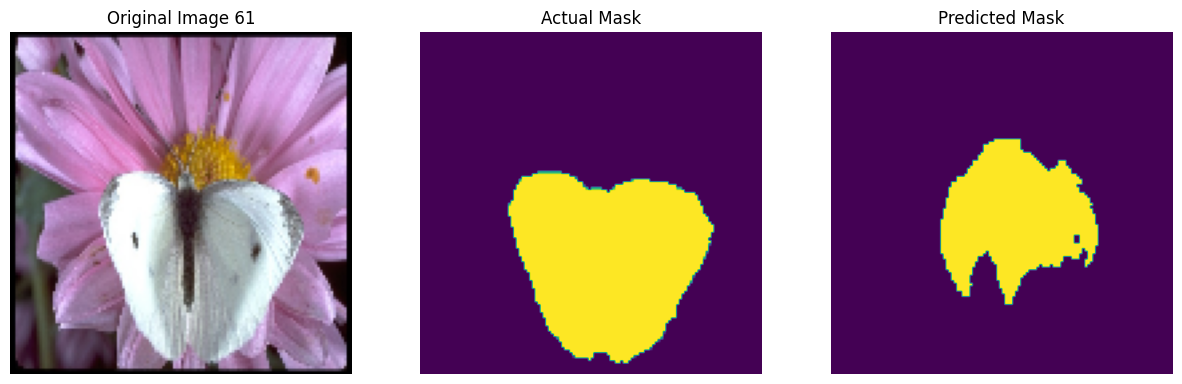

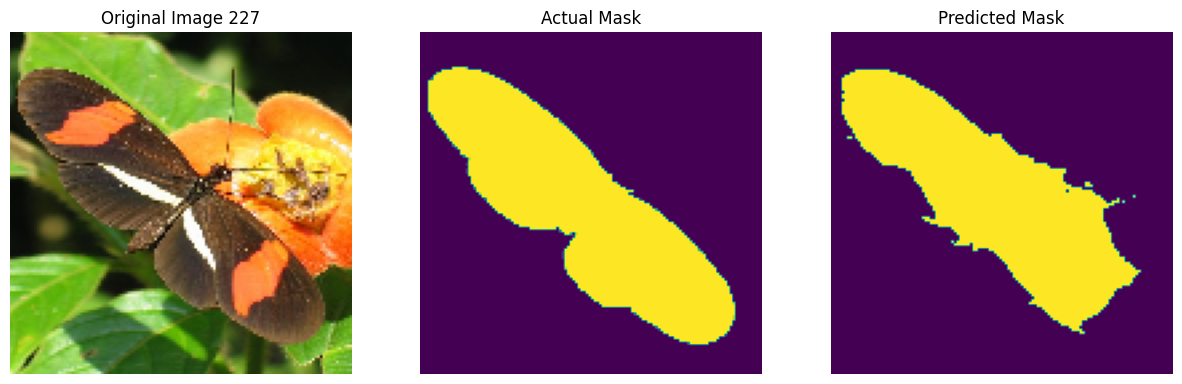

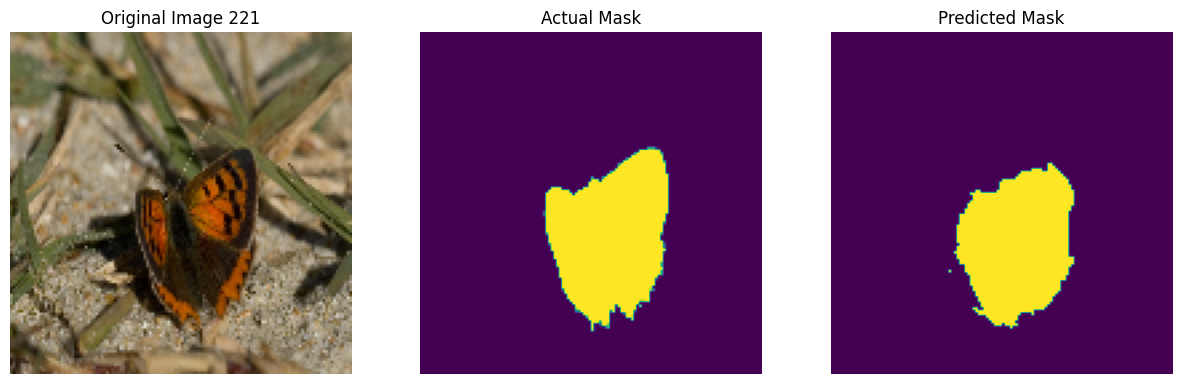

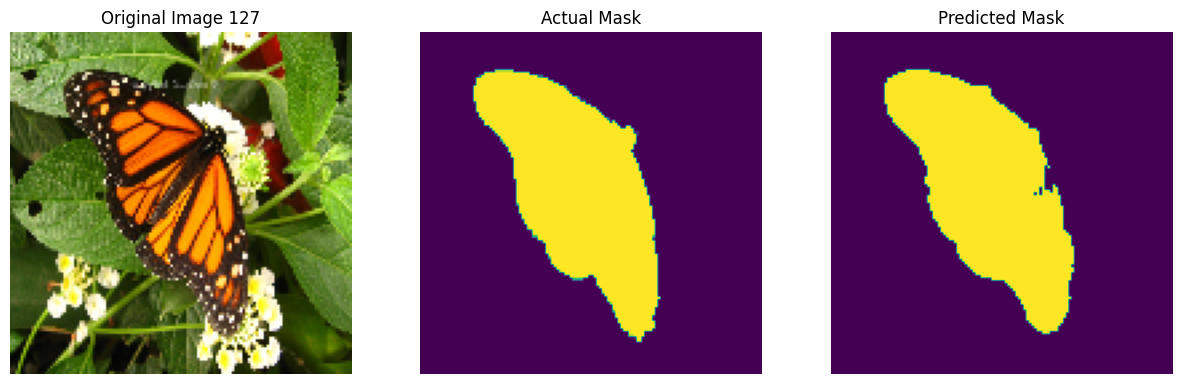

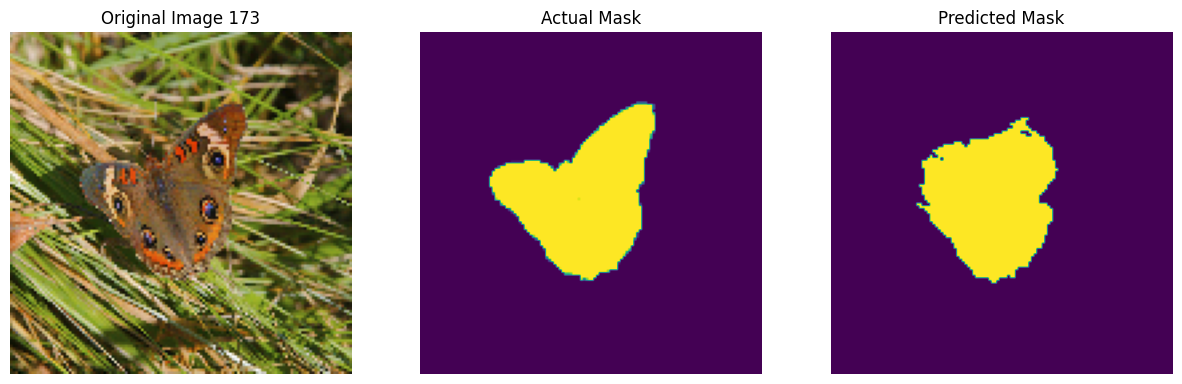

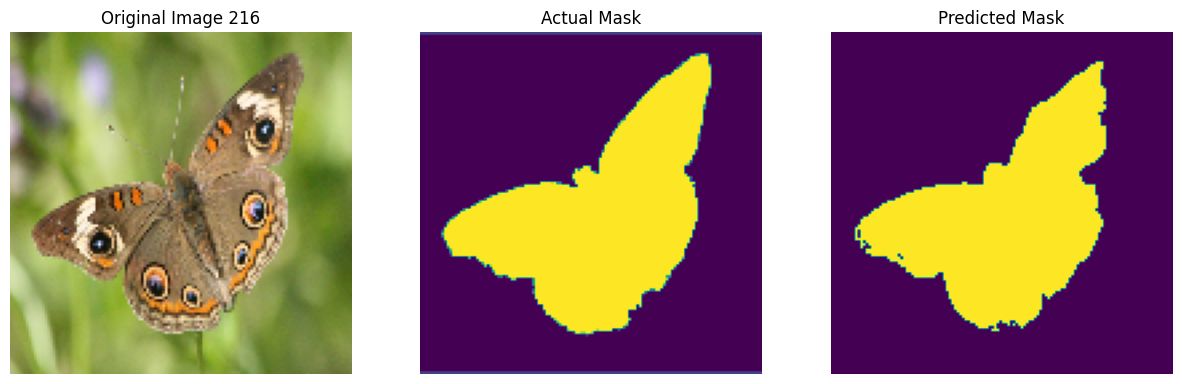

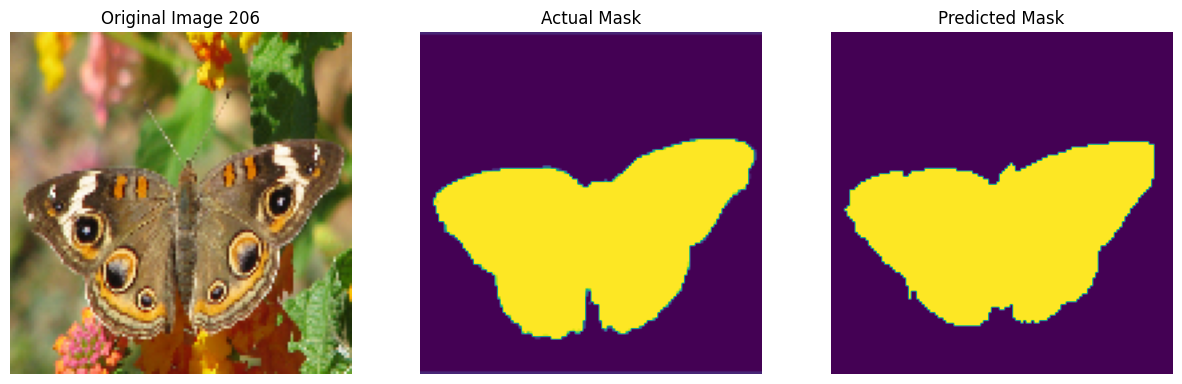

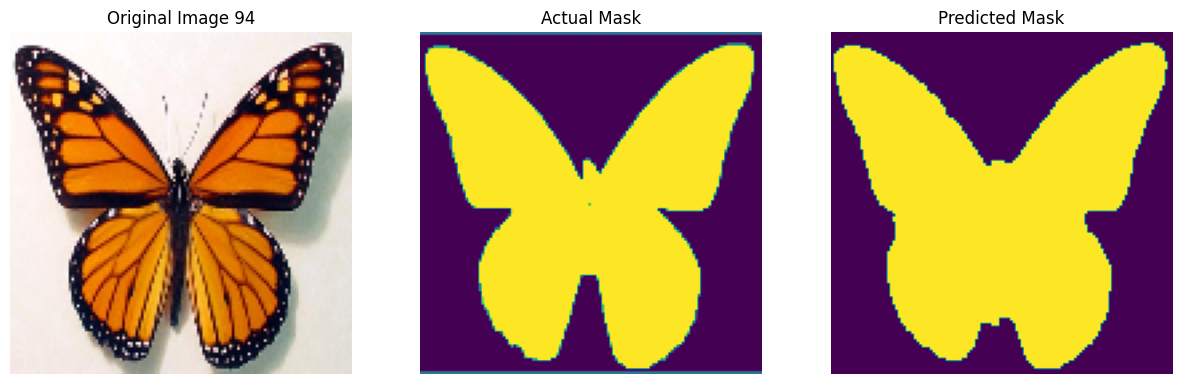

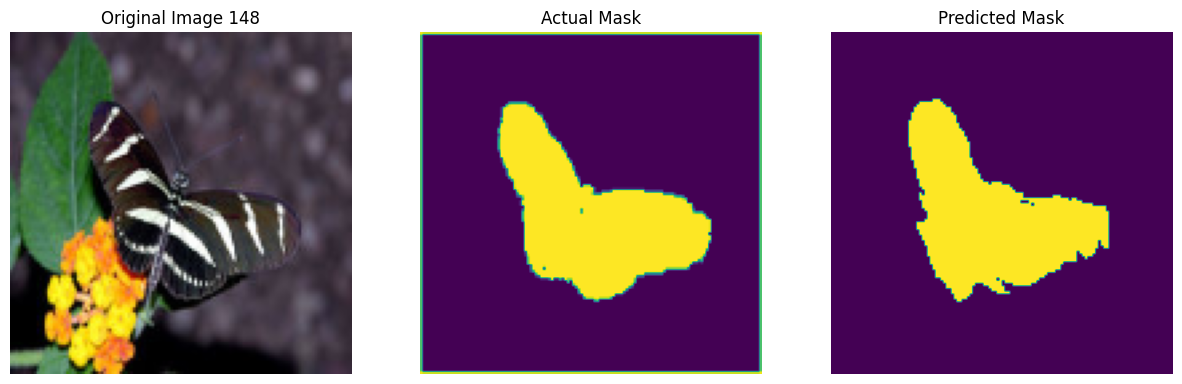

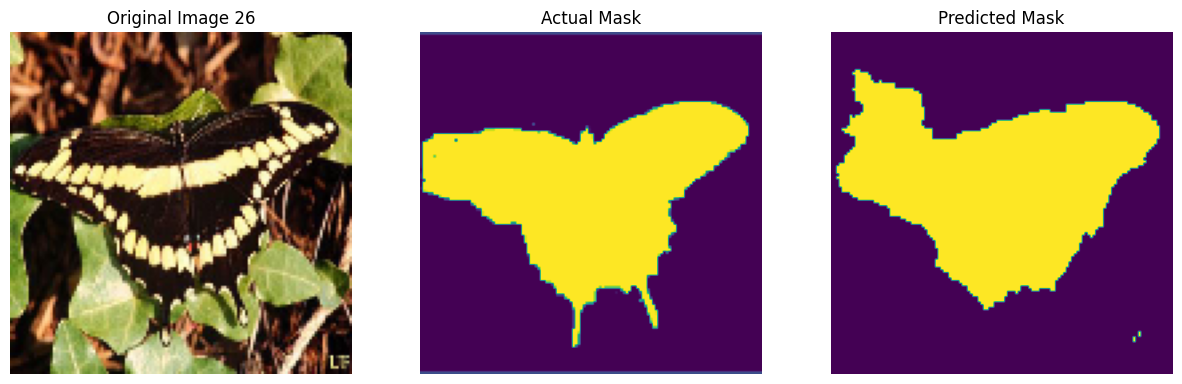

In [33]:
def plot_preds(idx,images_test,masks_test):
  """This function plots a test image, it's actual mask and the predicted
  mask side by side."""
  plt.figure(figsize = (15, 15))
  test_img = images_test[idx]
  test_img = tf.expand_dims(test_img, axis = 0)
  test_img = tf.expand_dims(test_img, axis = -1)
  pred = model.predict(test_img)
  pred = pred.squeeze()
  thresh = pred > 0.5
  plt.subplot(1,3,1)
  plt.imshow(images_test[idx])
  plt.title(f'Original Image {idx}')
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.imshow(masks_test[idx])
  plt.title('Actual Mask')
  plt.axis('off')
  plt.subplot(1,3,3)
  plt.imshow(thresh)
  plt.title('Predicted Mask')
  plt.axis('off')
  plt.savefig("Test_Result.png")
#plotting 10 random images with their true and predicted masks
for i in [random.randint(0, 230) for i in range(10)]:
    plot_preds(i,test_img,test_mask)

1/1 [==============================] - 0s 19ms/step


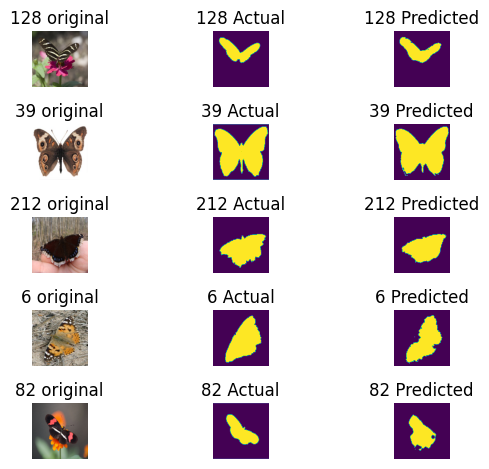

In [34]:
import random
import matplotlib.pyplot as plt
def plot_Test(images, masks):
  """
  Plots 5 random images and their corresponding masks and predicted in 3 rows.
  Args:
    images: A list of image paths.
    masks: A list of mask paths, corresponding to the images.
  """
  # Select 5 random images and masks images
  selected_img = random.sample(range(len(images)), 5)
  # Create a figure with 2 rows and 5 columns
  fig, axes = plt.subplots(5, 3)
  # Plot images and masks
  for j ,i in enumerate(selected_img):
#     print(i)
    test_img=images[i]
    img = tf.expand_dims(test_img, axis = 0)
    img = tf.expand_dims(img, axis = -1)
    pred = model.predict(img)
    pred = pred.squeeze()
    pred = pred > 0.5
      # Plot image
    axes[j, 0].imshow(test_img)
    axes[j, 0].set_title(f"{i} original")
    axes[j, 0].axis("off")

      # Plot mask
    axes[j, 1].imshow(masks[i])
    axes[j, 1].set_title(f"{i} Actual")
    axes[j, 1].axis("off")
#         plot predicted
    axes[j, 2].imshow(pred)
    axes[j, 2].set_title(f"{i} Predicted")
    axes[j, 2].axis("off")
  plt.tight_layout()
  plt.savefig("Test_result_.png")
  plt.show()
plot_Test(test_img, test_mask)

In [35]:
model_dir = os.path.join(wandb.run.dir, "saved_model")
model.save(model_dir)
wandb.log_artifact(model_dir, name="saved_model", type="model")
wandb.save("/kaggle/input/butterfly-dataset/leedsbutterfly", policy="now")
wandb.save("/kaggle/working/training_analysi.png")
wandb.save("/kaggle/working/Test_Result.png")
wandb.save("/kaggle/working/Test_Result_.png")
wandb.save("/kaggle/working/model_arch.png")

wandb: Adding directory to artifact (/content/wandb/run-20240217_171204-3f9n9otd/files/saved_model)... Done. 2.1s
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


[]

In [37]:
# prompt: wandb save trained model in .h5

model.save('/kaggle/working/model.h5')
wandb.save('/kaggle/working/model.h5')


['/content/wandb/run-20240217_171204-3f9n9otd/files/model.h5']